# Objective

The objective of this notebook is to develop machine learning models that accurately predict crime categories based on the given dataset for [Crime Category Prediction Challenge](https://kaggle.com/competitions/crime-cast-forecasting-crime-categories). The evaluation metric of the competition is the `accuracy score`.

# Setting Up the Environment and Importing Libraries
Set up the environment to install scikit-learn 1.5 to get access to the target encoder and ignore warnings for a cleaner output. Also, import the necessary libraries for data manipulation (Pandas, NumPy), machine learning algorithms and model evaluation (scikit-learn), and various visualization tools (Matplotlib, Seaborn, Plotly). 

In [1]:
!pip install scikit-learn==1.5 --quiet 2> /dev/null

import warnings 
warnings.filterwarnings('ignore')

import sklearn
print(sklearn.__version__)

1.5.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder,StandardScaler,LabelEncoder,OneHotEncoder,label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold,HalvingGridSearchCV,HalvingRandomSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier,OutputCodeClassifier
from sklearn.ensemble import AdaBoostClassifier,HistGradientBoostingClassifier,BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,VotingClassifier,StackingClassifier
from scipy.stats import randint,loguniform
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,RocCurveDisplay,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from itertools import cycle
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

# Loading the data
Load the training and test datasets for the competition.

In [3]:
# specify type of the columns that are parsed incorrectly on default settings
dtype_dict = {
    'Area_ID': str,
    'Reporting_District_no': str,
    'Part 1-2': str,
    'Premise_Code': str,
    'Weapon_Used_Code': str
}

# Loading the train dataset
X = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv',dtype=dtype_dict, parse_dates=['Date_Reported','Date_Occurred'])

# Loading the test dataset
X_t = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv',dtype=dtype_dict, parse_dates=['Date_Reported','Date_Occurred'])

# Exploratory Data Analysis

Perform data exploration to understand the dataset's structure, identify patterns, and uncover insights.

In [4]:
X.head(n=10).T

,0,1,2,3,4,5,6,7,8,9
Location,4500 CARPENTER AV,45TH ST,600 E MARTIN LUTHER KING JR BL,14900 ORO GRANDE ST,7100 S VERMONT AV,300 N AVENUE 57,1600 N SOTO ST,12600 BRADDOCK DR,5500 COLDWATER CA AV,11500 AVIATION BL
Cross_Street,NaN,ALAMEDA ST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,34.1522,34.0028,34.0111,34.2953,33.9787,34.1127,34.0623,33.9864,34.1781,33.9298
Longitude,-118.391,-118.2391,-118.2653,-118.459,-118.2918,-118.1942,-118.198,-118.4239,-118.4179,-118.3784
Date_Reported,2020-03-09 00:00:00,2020-02-27 00:00:00,2020-08-21 00:00:00,2020-11-08 00:00:00,2020-02-25 00:00:00,2020-01-10 00:00:00,2020-08-17 00:00:00,2021-10-07 00:00:00,2020-01-28 00:00:00,2020-07-07 00:00:00
Date_Occurred,2020-03-06 00:00:00,2020-02-27 00:00:00,2020-08-21 00:00:00,2020-11-06 00:00:00,2020-02-25 00:00:00,2020-01-10 00:00:00,2020-08-17 00:00:00,2020-03-19 00:00:00,2020-01-26 00:00:00,2020-07-07 00:00:00
Time_Occurred,1800.0,1345.0,605.0,1800.0,1130.0,256.0,1840.0,1100.0,1600.0,445.0
Area_ID,15.0,13.0,13.0,19.0,12.0,11.0,4.0,14.0,9.0,14.0
Area_Name,N Hollywood,Newton,Newton,Mission,77th Street,Northeast,Hollenbeck,Pacific,Van Nuys,Pacific
Reporting_District_no,1563.0,1367.0,1343.0,1924.0,1245.0,1118.0,448.0,1455.0,939.0,1499.0


### Observations
1. Area_Name, Premise_Description,  Weapon_Description, Status_Description are description of Area_ID, Premise_Code, Weapon_Used_Code, and Status, respectively. So I will use them interchangeably from here on.
2. Modus_Operandi column which describes the activities associated with the suspect has several codes separated by space. So they need to be extracted out.

In [6]:
X.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Location,20000,12399,6TH,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cross_Street,3448,1495,BROADWAY,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,20000.0,NaN,NaN,NaN,33.940704,0.0,34.0092,34.0587,34.165025,34.3281,2.12681
Longitude,20000.0,NaN,NaN,NaN,-117.893072,-118.6634,-118.4297,-118.323,-118.2744,0.0,7.377726
Date_Reported,20000,NaN,NaN,NaN,2020-07-20 22:59:13.920000,2020-01-01 00:00:00,2020-04-06 00:00:00,2020-07-09 00:00:00,2020-10-10 00:00:00,2024-01-23 00:00:00,NaN
Date_Occurred,20000,NaN,NaN,NaN,2020-06-28 20:06:25.920000,2020-01-01 00:00:00,2020-03-29 00:00:00,2020-06-28 00:00:00,2020-09-28 00:00:00,2020-12-31 00:00:00,NaN
Time_Occurred,20000.0,NaN,NaN,NaN,1352.38035,1.0,930.0,1430.0,1900.0,2359.0,646.100291
Area_ID,20000,21,12.0,1345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Area_Name,20000,21,77th Street,1345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reporting_District_no,20000,1120,645.0,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Observations
1. Latitude and longitude have 0 as the minimum and maximum value, respectively.
2. Age has some implausible values, like -2.
3. Summary of the Type of Columns:

| Column                  | Location            | Cross_Street       | Latitude | Longitude | Date_Reported  | Date_Occurred | Time_Occurred | Area_ID | Area_Name | Reporting_District_no | Part 1-2 | Modus_Operandi | Victim_Age | Victim_Sex | Victim_Descent | Premise_Code | Premise_Description | Weapon_Used_Code | Weapon_Description | Status | Status_Description | Crime_Category |
|-------------------------|----------------------|--------------------|----------|-----------|----------------|---------------|---------------|---------|-----------|------------------------|----------|----------------|------------|------------|----------------|--------------|---------------------|------------------|--------------------|--------|---------------------|----------------|
| Type                    | Nominal (High Cardinality) | Nominal (High Cardinality) | Numerical | Numerical | Datetime           | Datetime          | Numerical     | Nominal (Low Cardinality) | Nominal (Low Cardinality) | Nominal (High Cardinality) | Nominal (Low Cardinality) | Nominal (High Cardinality) | Numerical | Nominal (Low Cardinality) | Nominal (Low Cardinality) | Nominal (High Cardinality) | Nominal (High Cardinality) | Nominal (Low Cardinality) | Nominal (Low Cardinality) | Nominal (Low Cardinality) | Nominal (Low Cardinality) | Nominal (Low Cardinality) | Nominal (Low Cardinality) | Nominal (Low Cardinality) |
| Number of Categories    | 12399                | 1495               | N/A      | N/A       | N/A            | N/A          | N/A           | 21      | 21        | 1120                   | 2        | 10489          | N/A        | 4          | 17             | 217          | 216                 | 57               | 57                 | 5      | 5                   | 6              |

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Location               20000 non-null  object        
 1   Cross_Street           3448 non-null   object        
 2   Latitude               20000 non-null  float64       
 3   Longitude              20000 non-null  float64       
 4   Date_Reported          20000 non-null  datetime64[ns]
 5   Date_Occurred          20000 non-null  datetime64[ns]
 6   Time_Occurred          20000 non-null  float64       
 7   Area_ID                20000 non-null  object        
 8   Area_Name              20000 non-null  object        
 9   Reporting_District_no  20000 non-null  object        
 10  Part 1-2               20000 non-null  object        
 11  Modus_Operandi         17259 non-null  object        
 12  Victim_Age             20000 non-null  float64       
 13  V

In [8]:
print(X[X.Premise_Description.isnull()].Premise_Code.value_counts())
print(X[X.Premise_Code=='418.0'].Premise_Description.value_counts(dropna=False))

Premise_Code
418.0    5
Name: count, dtype: int64
Premise_Description
NaN    5
Name: count, dtype: int64


### Observations
1. `418.0` Premise_Code is used for the rows with null values for Premise_Description. 
2. Cross_Street, Modus_Operandi, Victim_Sex , Victim_Descent, Weapon_Description have missing values with Cross_Street having about 83% of its values missing.

In [9]:
((X[(X.Victim_Age==0)&X.Victim_Sex.isna()].isnull().sum()/X.isnull().sum())*100).dropna()

Cross_Street           12.826245
Modus_Operandi         95.549070
Victim_Sex             99.961890
Victim_Descent         99.961890
Premise_Description     0.000000
Weapon_Used_Code       20.702724
Weapon_Description     20.702724
dtype: float64

### Observation
1. 99.96% of the times when Victim_Sex and Victim_Descent were missing, 0 was used for Victim_Age. 
2. 95.54% of the times when Victim_Age was 0 and Victim_Sex was missing, Modus_Operandi was missing as well.

These might indicate that there were no victim or no single victim of the crime.

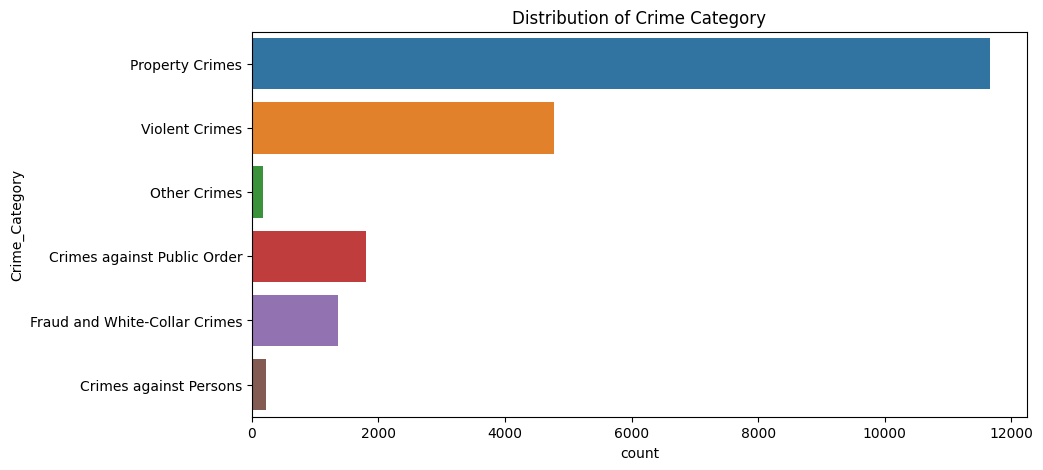

In [10]:
# distribution of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(data=X, y='Crime_Category')
plt.title('Distribution of Crime Category')
plt.show()

### Observations
1. Property Crimes has the most number of examples, more than the double of the next crime category, Violent Crimes.
2. Crimes against Persons and Other Crimes (Crimes that donot belong to any specific category) have lesser than 300 examples.

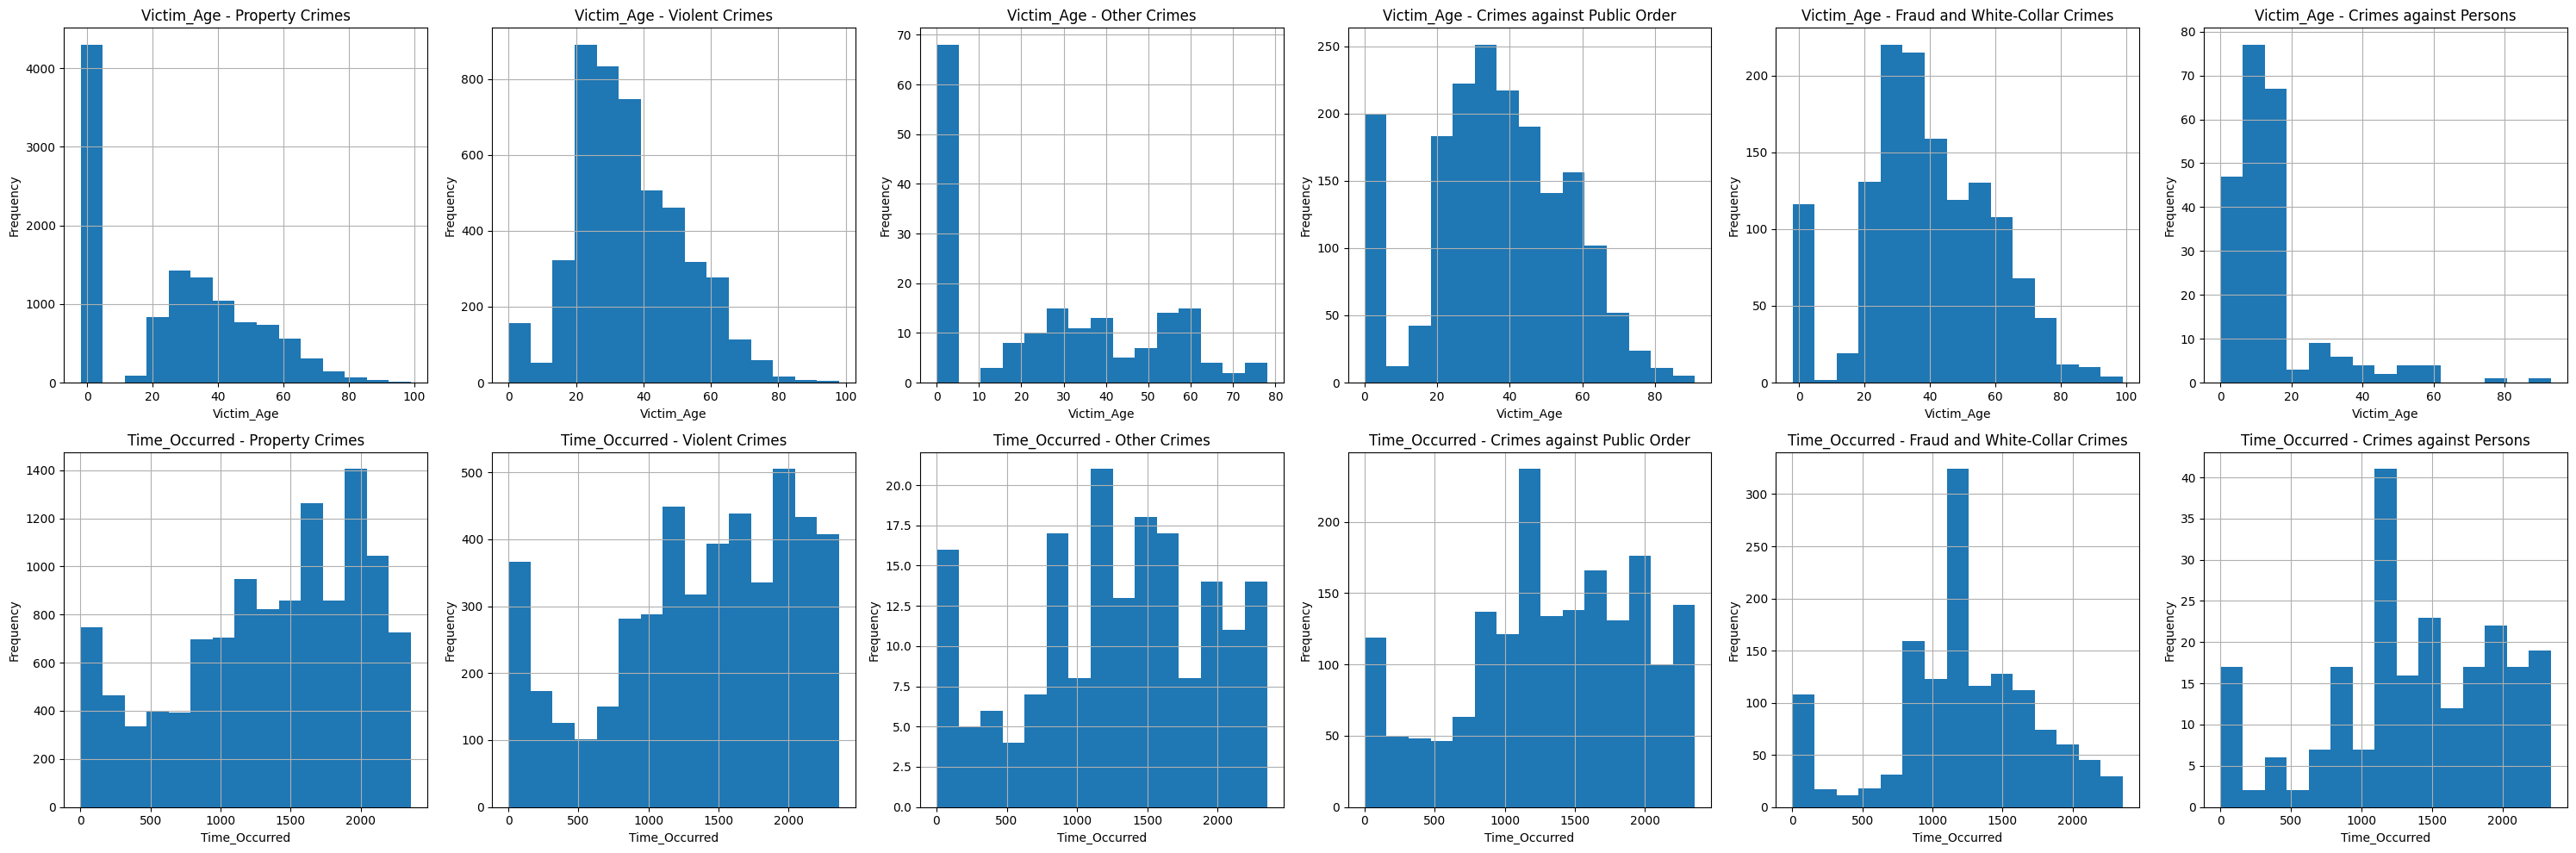

In [11]:
# Define the numerical columns
numerical_columns = ['Victim_Age', 'Time_Occurred']

# Get unique crime categories
crime_categories = X['Crime_Category'].unique()

# Number of rows and columns for subplots
num_cols = len(crime_categories)
num_rows = len(numerical_columns)

# Set up the matplotlib figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

# Plot each numerical column for each crime category
for i, num_col in enumerate(numerical_columns):
    for j, category in enumerate(crime_categories):
        ax = axes[i, j]
        subset = X[X['Crime_Category'] == category]
        subset[num_col].hist(bins=15, ax=ax)
        ax.set_title(f'{num_col} - {category}')
        ax.set_xlabel(num_col)
        ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Observations
1. **Victim Age:**
   - For the majority of crime categories, The `Victim_Age` variable exhibits a high frequency of zeros, likely indicating cases where there was no identified victim or no single victim involved, as examined above.
   - For the majority of crime categories, `Victim_Age` typically peaks between 20 to 40 years, with number of cases dripping for younger and older ages. An exception is seen in "Other Crimes," where the distribution of `Victim_Age` appears more uniform across all age groups. Notably, in crimes against persons, `Victim_Age` is predominantly concentrated between 0 to 20 years.
   

2. **Time Occurred:**
   - Across most crime categories, there is a noticeable decrease in the number of crimes committed during the morning hours, followed by an increase later in the day, with the frequency remaining constant or even increasing during nighttime, particularly for violent crimes. However, for fraud and other white-collar crimes, while the frequency of incidents is lower in the morning, similar to other crime categories, it peaks between 10 a.m. and 3 p.m. before declining.

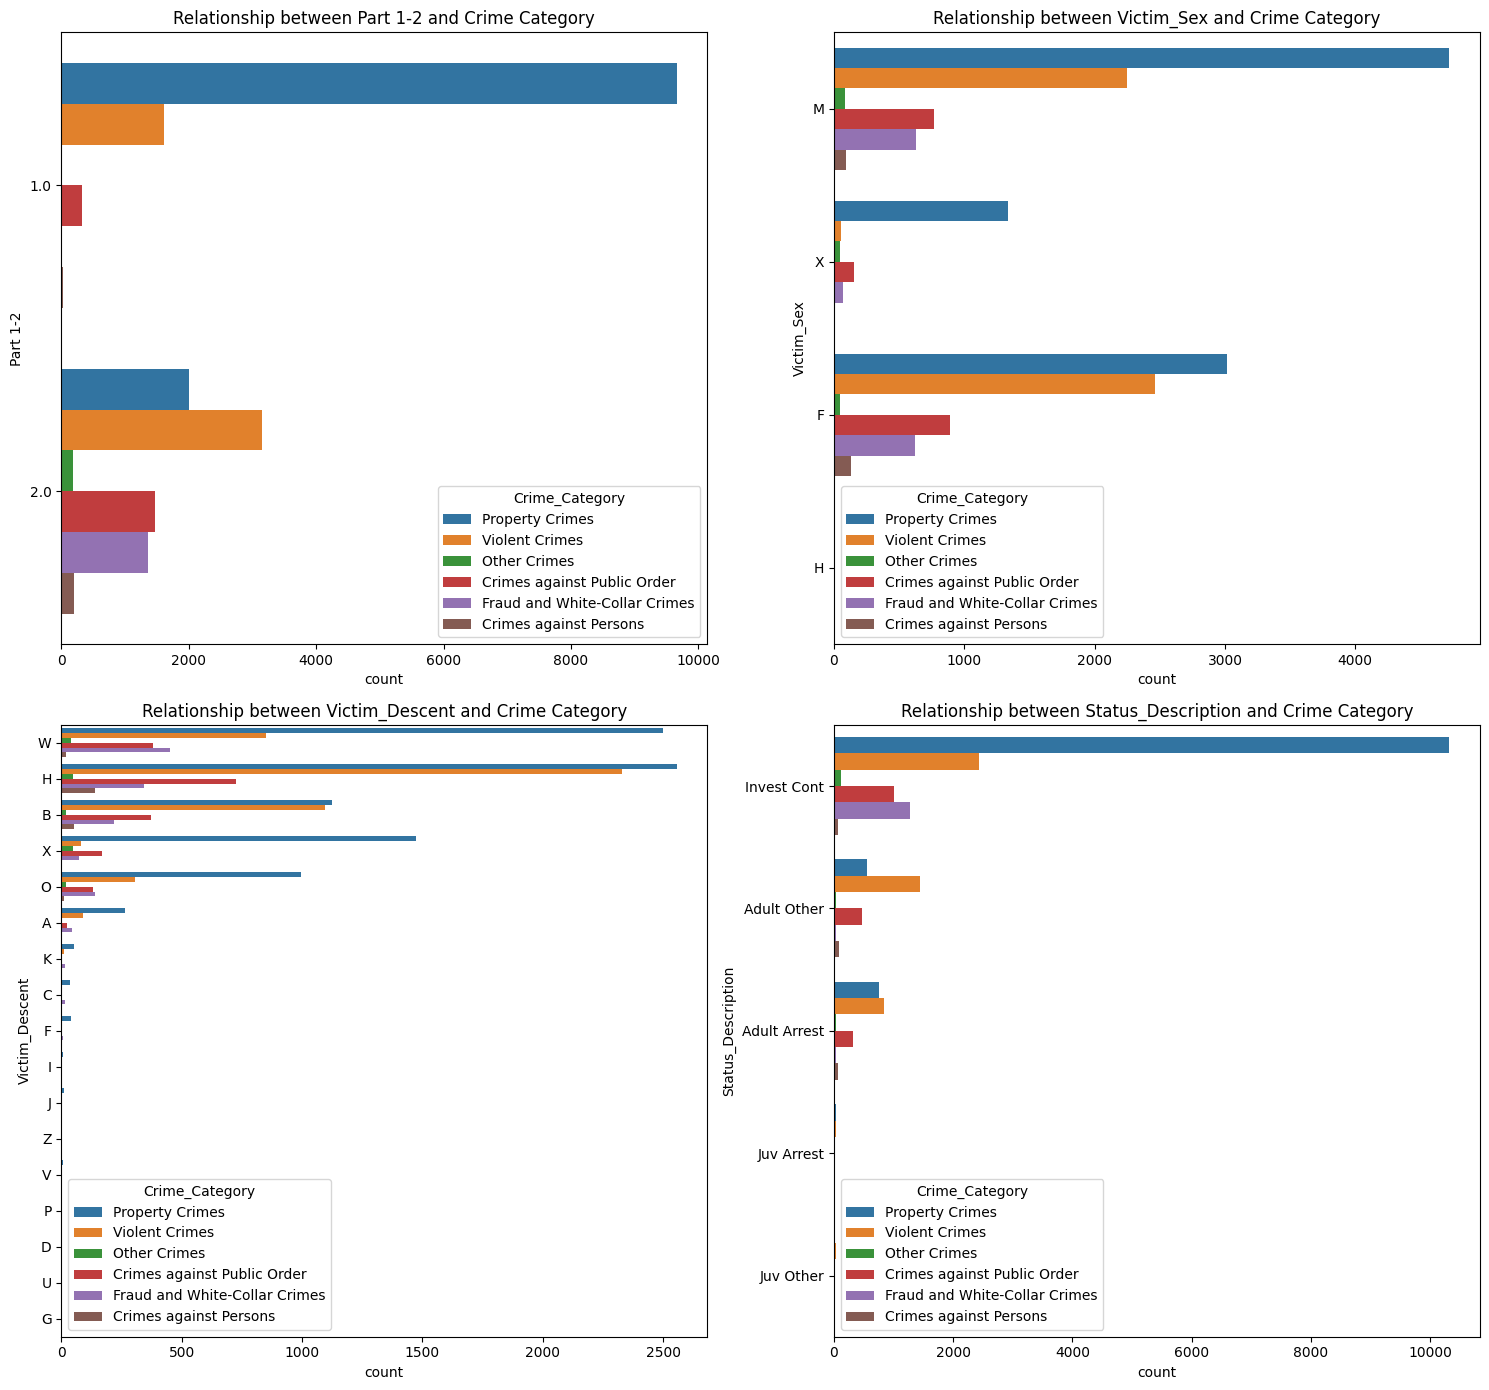

In [12]:
# Plot distribution for nominal columns with low cardinality
nominal_columns_low_cardinality = ['Part 1-2','Victim_Sex','Victim_Descent','Status_Description']

# Number of rows and columns for subplots
num_cols = 2
num_rows = (len(nominal_columns_low_cardinality) + 1) // num_cols

# Set up the matplotlib figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7 * num_rows))

# Plot each column
for i, col in enumerate(nominal_columns_low_cardinality):
    sns.countplot(data=X, y=col, ax=axes[i // num_cols, i % num_cols],hue='Crime_Category')
    axes[i // num_cols, i % num_cols].set_title(f'Relationship between {col} and Crime Category')

# Remove any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j // num_cols, j % num_cols])

# Adjust layout
plt.tight_layout()
plt.show()

### Observations

1. **Part 1-2:**
   - Property crimes are primarily classified as Part 1 crimes.
   - Fraud and white-collar crimes,other crimes and crimes against persons tend to be categorized as Part 2 crimes.


2. **Victim Sex:**
   - The distribution of crime categories across male (M) and female (F) victims is generally similar. However, males are victims of more property crimes compared to females.
   - The "X" (mostly probably representing unknown) category predominantly represents property crimes.


3. **Victim Descent:**
   - Property crime is the most prevalent across all victim descent categories.
   - Victims with descent H and B experience nearly equal numbers of violent and property crimes. Other descent categories have significantly fewer violent crimes compared to property crimes.


4. **Status:**
   - Most property crimes, fraud and white-collar crimes, and other crimes are marked with an "Invest Cont." status.

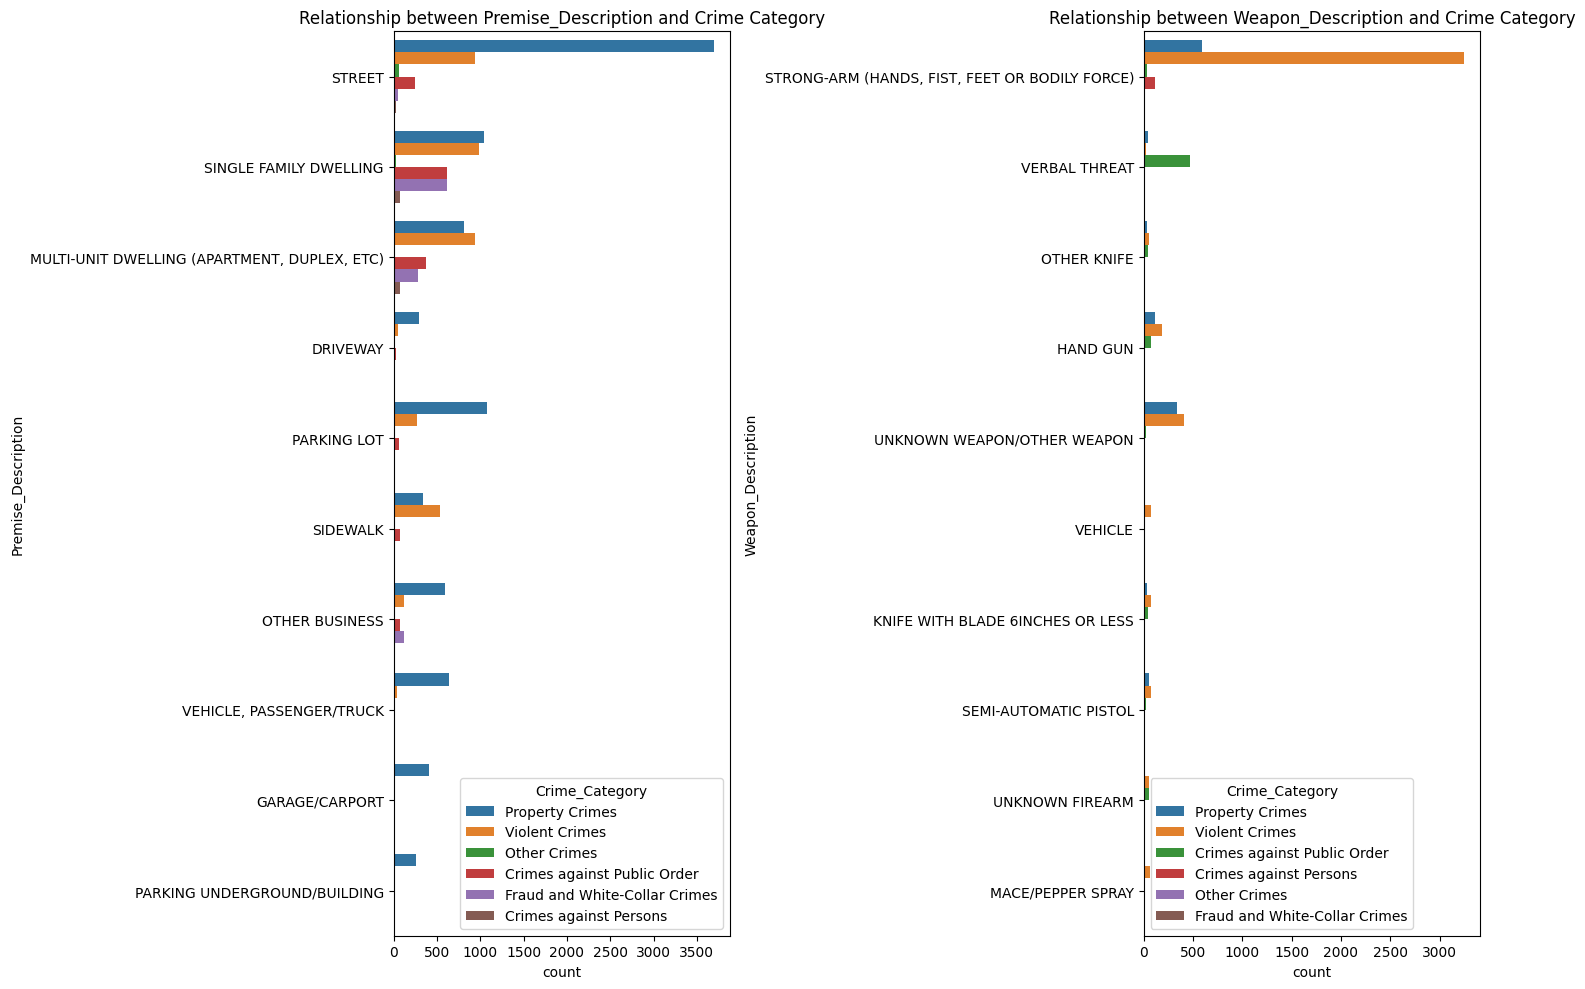

In [13]:
nominal_columns_high_cardinality = ['Premise_Description','Weapon_Description'] 
# Weapon_Description is categorized earlier as low cardinality, however as it has 57 categories 
# which are not possible to vizualize in a single chart that's why it is considered as high cardinality here


# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Plot each column for top 10 values
for i, col in enumerate(nominal_columns_high_cardinality):
    top_values = X[col].value_counts().nlargest(10).index
    sns.countplot(data=X[X[col].isin(top_values)], y=col, ax=axes[i],hue='Crime_Category')
    axes[i].set_title(f'Relationship between {col} and Crime Category')

# Adjust layout
plt.tight_layout()
plt.show()

### Observations

1. **Premise:**
   - In the top 10 premises where crimes occurred, property crimes dominate in 7 of these categories by a significant margin.
   - For the remaining 3 premises—single-family dwellings, multi-unit dwellings, and sidewalks—the number of violent crimes is either equal to or greater than the number of property crimes.
   

2. **Weapon:**
   - In the top 10 weapon categories, strong arms and fists are predominantly linked to violent crimes.
   - Verbal threats are primarily associated with crimes against public order.

In [8]:
# Grouping data by date and crime category
time_series_reported =X.groupby(['Crime_Category','Date_Reported']).size().reset_index(name='counts')
time_series_occurred =X.groupby(['Crime_Category','Date_Occurred']).size().reset_index(name='counts')

figures=[]
for category in X['Crime_Category'].unique():
    figures.append(go.Scatter(
        name=f'Occurred-{category}',
        x=time_series_occurred[time_series_occurred['Crime_Category']==category]['Date_Occurred'].dt.date,
        y=time_series_occurred[time_series_occurred['Crime_Category']==category]['counts'],
        mode='lines',
    ))
    figures.append(go.Scatter(
        name=f'Reported-{category}',
        x=time_series_reported[time_series_reported['Crime_Category']==category]['Date_Reported'].dt.date,
        y=time_series_reported[time_series_reported['Crime_Category']==category]['counts'],
        mode='lines'
    ))
    
fig = go.Figure(figures)
fig.update_layout(
    yaxis_title='Number of Crimes',
    title='Crime Over Time by Crime Categories',
    hovermode="x",
    height=750,width=1000
)
fig.show()

### Observations

1. Across all crime categories, the year of occurrence is consistently 2020, while the year reported spans from 2020 to 2024.
2. The reporting pattern closely mirrors the occurrence pattern, with fluctuations in the date occurred series being reflected in the date reported series.
3. Both series for each crime category fluctuate around a mean value.
4. For most crime categories, that mean values of both the occurrence and reporting series are nearly identical; however, the mean of the date reported series for the fraud and white collar crimes is slightly lower than that of its date occurred series.


In [6]:
# Vizualizing the crime locations
fig = px.scatter_mapbox(X,lat="Latitude",lon="Longitude",
                        color='Crime_Category',hover_name='Location',
                        hover_data='Area_Name',zoom=9,height=750,
                        width=1000,title="Map of Crime by Crime Category")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

### Observations

1. Most data points are concentrated in Los Angeles, suggesting that latitude and longitude values of 0 likely indicate unknown coordinates.
2. Across all crime categories, the data shows greater dispersion in the upper region, while in the central region, it is more tightly clustered.

# **Data Preprocessing**

1. **Handling Missing Victim Age:**
   - Replaced invalid `Victim_Age` values (0, -2, -1) with -10 for records where `Victim_Sex` is missing. This adjustment helps differentiate between missing and actual age values during model training.
   

2. **Extracting Time Features:**
   - Extracted the year, month, and day from both the `Date_Reported` and `Date_Occurred` columns to generate the following features:
     - `Year_Reported`, `Month_Reported`, `Day_Reported`
     - `Month_Occurred`, `Day_Occurred`
   - This step enhances temporal analysis by breaking down the date columns into more granular components, enabling the model to capture time-based patterns.
   

3. **Dropping Unused Columns:**
   - Removed unnecessary columns to reduce data dimensionality and avoid redundancy:
     - `Date_Reported` and `Date_Occurred`: These were dropped as their components (year, month, and day) were already extracted.
     - `Cross_Street`: Dropped due to 83% of values being unknown, making it less useful for analysis.
     - `Area_Name`, `Premise_Description`, `Weapon_Description`, and `Status_Description`: These were redundant as their corresponding counterparts were already used in the model (e.g., `Area_ID`, `Premise_Code`, `Weapon_Used_Code`, `Status`).
   

4. **Imputing Latitude and Longitude:**
   - Developed a custom transformer (`LatitudeLongitudeImputer`) to impute missing latitude and longitude values for rows where both are zero. The imputation was based on the average latitude and longitude of the corresponding `Area_ID`, ensuring that geographic coordinates are accurately filled for missing entries.
   

5. **Splitting the Dataset:**
   - Used `train_test_split` to divide the dataset into training and validation sets with an 80/20 split. The stratification based on `Crime_Category` ensured balanced distribution of crime categories between the training and validation datasets, maintaining consistency for model training and evaluation.
   

6. **Defining and Transforming Categorical Features:**
   - **High Cardinality Columns:**  
     Applied `TargetEncoder` to features with a large number of unique values, such as `Location`, `Premise_Code`, and `Reporting_District_no`. Target encoding replaced categories with their respective mean target values, which is helpful for high cardinality features.
   - **Low Cardinality Columns:**  
     Applied one-hot encoding to columns with fewer unique values, such as `Area_ID`, `Part 1-2`, `Victim_Sex`, `Victim_Descent`, `Weapon_Used_Code`, and `Status`. This transformation expanded these categorical variables into binary features to ensure proper numerical representation.


7. **Transforming Modus Operandi Column:**
   - Implemented a pipeline that used `SimpleImputer` to fill missing values with `'0'`, followed by `CountVectorizer` to one-hot encode the `Modus_Operandi` column. This approach treated each unique code in the `Modus_Operandi` column as a binary feature.


8. **Scaling the Data:**
   - Applied `StandardScaler` to the transformed feature matrices, standardizing all numeric columns to have a mean of 0 and a standard deviation of 1. This scaling step is critical for machine learning models that rely on distance calculations (e.g., KNN, SVM) or assume features are on the same scale.


9. **Encoding the Target Variable:**
   - Converted the `Crime_Category` target variable from categorical labels to numerical labels using `LabelEncoder`, making it compatible with machine learning algorithms.


10. **Final Transformation of Datasets:**
    - Used the defined pipelines to transform the training, validation, and test datasets (`X_train`, `X_val`, `X_test`) into numerical formats, preparing them for the modeling phase.
    - The `LabelEncoder` was also applied to the target variable in both training (`y_train`) and validation (`y_val`) sets.


In [4]:
def clean_and_split_features(X):
    
    # replace the unknown ages with impossible value
    X.loc[X.Victim_Sex.isna(), 'Victim_Age'] = X.loc[X.Victim_Sex.isna(), 'Victim_Age'].replace([0, -2, -1], -10)
    
    # separating the year, month, and day of the time series columns 
    X['Year_Reported'] = X.Date_Reported.dt.year
    X['Month_Reported'] = X.Date_Reported.dt.month
    X['Month_Occurred'] = X.Date_Occurred.dt.month
    X['Day_Reported'] = X.Date_Reported.dt.day
    X['Day_Occurred'] = X.Date_Occurred.dt.day
    
    # dropping the unused fields
    X.drop(['Date_Reported', 'Date_Occurred', 'Cross_Street', 'Area_Name', 'Premise_Description', 'Weapon_Description', 'Status_Description'], axis=1, inplace=True)
    
clean_and_split_features(X)
clean_and_split_features(X_t)

In [5]:
# splitting the training dataset into validation and training data
X_train, X_val, y_train, y_val = train_test_split(X.drop('Crime_Category',axis=1), X['Crime_Category'],test_size=0.2,random_state=0,stratify=X['Crime_Category'])

In [6]:
# latitude-longitude imputer
class LatitudeLongitudeImputer(BaseEstimator, TransformerMixin):
    
    lat_lon = None
    
    def fit(self, X, y = None):
        self.lat_lon = X[(X.Latitude!=0)&X.Area_ID.isin(X[(X.Latitude==0)&(X.Longitude==0)].Area_ID)].groupby('Area_ID')[['Latitude','Longitude']].mean()
        return self 
    
    def transform(self, X, y = None):
        X_transformed = X.apply(self.impute_lat_lon, axis=1)
        return X_transformed
    
    def fit_transform(self,X,y = None):
        self.fit(X)
        return self.transform(X)
        
    
    def impute_lat_lon(self,row):
        if row['Latitude'] == 0 and row['Longitude'] == 0:
            rd_no = row['Area_ID']
            if rd_no in self.lat_lon.index:
                row['Latitude'] = self.lat_lon.at[rd_no, 'Latitude']
                row['Longitude'] = self.lat_lon.at[rd_no, 'Longitude']
        return row

In [7]:
# defining the transformers

transformerY = LabelEncoder()

transformerX = make_pipeline(
    LatitudeLongitudeImputer(),
    make_column_transformer(
    ( TargetEncoder(random_state=0), ['Location','Premise_Code','Reporting_District_no'] ),
    (
        make_pipeline(
            SimpleImputer(strategy='constant',fill_value="missing"),
            OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first')
        ), ['Area_ID','Part 1-2','Victim_Sex','Victim_Descent','Weapon_Used_Code','Status']
    ),
    (
       make_pipeline(
            SimpleImputer(strategy='constant',fill_value='0'),
            CountVectorizer(preprocessor=lambda x:x[0])
        ),['Modus_Operandi']
    ),
    remainder='passthrough',sparse_threshold=0
    ), StandardScaler()
)

# Transforming the datasets and encoding the target variable

X_train_transformed = transformerX.fit_transform(X_train,y_train) 
X_test_transformed = transformerX.transform(X_t)
X_val_transformed = transformerX.transform(X_val)

y_train = transformerY.fit_transform(y_train)
y_val = transformerY.transform(y_val)

# Model Selection

The following models were tested using mostly out-of-the-box hyperparameters:
* Different Baseline models
    + <a href='#most_frequent'>Dummy classifer - with "most frequent" strategy</a>
    + <a href='#stratified'>Dummy classifer - with "stratified" strategy</a>
* Different Base estimators
    + <a href='#logistic_regression'>Logistic Regression</a>
    + <a href='#k_nearest_neighbours'>K Nearest Neighbours</a>
    + <a href='#c_support_vector'>C-Support Vector</a>
    + <a href='#decision_tree'>Decision Tree</a>
    + <a href='#multi_layer_perceptron'>Multi Layer Perceptron</a>
* Different multiclass strategies
    + <a href='#one_vs_one'>One Vs One</a>
    + <a href='#one_vs_rest'>One Vs Rest</a>
    + <a href='#output_code'>Output Code</a>
* Different Ensemble Models
    + <a href='#ada_boost'>Ada Boosting</a>
    + <a href='#gradient_boost'>Gradient Boosting</a>
    + <a href='#bagging'>Bagging</a>
    + <a href='#random_forest'>Random Forest</a>
    + <a href='#extra_tree'>Extra Tree</a>
    + <a href='#voting'>Voting</a>
    + <a href='#stacking'>Stacking</a>

In [9]:
def score(model):
    
    model.fit(X_train_transformed, y_train)
    print(f'Training Score: {round(model.score(X_train_transformed, y_train),5)}, Validation Score: {round(model.score(X_val_transformed, y_val),5)}')
    
    pipeline = make_pipeline(transformerX,model)
    scores = cross_val_score(pipeline,X_train,y_train,cv=StratifiedKFold(shuffle=True,random_state=0))
    print(f'Cross validation with 5 folds score: {round(scores.mean(),5)} accuracy with a standard deviation of {round(scores.std(),5)}')

## Different baseline models

<a id='most_frequent'></a>

In [21]:
dummy_most_frequent = DummyClassifier(strategy="most_frequent")

score(dummy_most_frequent)

Training Score: 0.58331, Validation Score: 0.58325
Cross validation with 5 folds score: 0.58331 accuracy with a standard deviation of 0.00015


<a id='stratified'></a>

In [22]:
dummy_stratified = DummyClassifier(strategy="stratified",random_state=np.random.RandomState(0))

score(dummy_stratified)

Training Score: 0.41144, Validation Score: 0.41625
Cross validation with 5 folds score: 0.40956 accuracy with a standard deviation of 0.00618


## Different Base Estimators

<a id='logistic_regression'></a>

In [23]:
# Logistic Regression
logistic = LogisticRegression(random_state=np.random.RandomState(0),solver='saga',max_iter=500,tol=0.001)

score(logistic)

Training Score: 0.96569, Validation Score: 0.9435
Cross validation with 5 folds score: 0.94275 accuracy with a standard deviation of 0.00294


<a id='k_nearest_neighbours'></a>

In [24]:
# K-nearest neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=6)

score(knn)

Training Score: 0.89744, Validation Score: 0.86375
Cross validation with 5 folds score: 0.86156 accuracy with a standard deviation of 0.00445


<a id='c_support_vector'></a>

In [25]:
# C-Support Vector with gaussian kernel
svm = SVC(random_state=np.random.RandomState(0))

score(svm)

Training Score: 0.96781, Validation Score: 0.9225
Cross validation with 5 folds score: 0.92219 accuracy with a standard deviation of 0.00223


<a id='decision_tree'></a>

In [26]:
# Decision Tree Classifier
decisiontree = DecisionTreeClassifier(random_state=np.random.RandomState(0))

score(decisiontree)

Training Score: 1.0, Validation Score: 0.92825
Cross validation with 5 folds score: 0.92662 accuracy with a standard deviation of 0.00451


<a id='multi_layer_perceptron'></a>

In [27]:
# Multi-Layer Perceptron
mlp = MLPClassifier(random_state=np.random.RandomState(0),hidden_layer_sizes=(100,50,50),max_iter=500,tol=0.001)

score(mlp)

Training Score: 1.0, Validation Score: 0.9345
Cross validation with 5 folds score: 0.93169 accuracy with a standard deviation of 0.00308


## Different multiclass strategies

<a id='one_vs_one'></a>

In [28]:
# One Vs One Classifier with Linear svm as base estimator
OVOlsv = OneVsOneClassifier(LinearSVC(dual="auto",random_state=np.random.RandomState(0)))

score(OVOlsv)

Training Score: 0.97875, Validation Score: 0.9375
Cross validation with 5 folds score: 0.93512 accuracy with a standard deviation of 0.00303


<a id='one_vs_rest'></a>

In [29]:
# One Vs Rest Classifier with Histogram-based Gradient Boosting Classifier as base estimator
OVRgb = OneVsRestClassifier(HistGradientBoostingClassifier(random_state=np.random.RandomState(0)))

score(OVRgb)

Training Score: 0.99344, Validation Score: 0.95575
Cross validation with 5 folds score: 0.95569 accuracy with a standard deviation of 0.00336


<a id='output_code'></a>

In [30]:
# Output Code Classifier with MLP as base estimator
OpCmlp = OutputCodeClassifier(
    MLPClassifier(random_state=np.random.RandomState(0),hidden_layer_sizes=(100,50,50),max_iter=500,tol=0.001),
    random_state=np.random.RandomState(0))

score(OpCmlp)

Training Score: 1.0, Validation Score: 0.92925
Cross validation with 5 folds score: 0.93425 accuracy with a standard deviation of 0.00254


## Different Ensemble Models

<a id='ada_boost'></a>

In [31]:
# Ada-boosting Classifier
adaboost = AdaBoostClassifier(algorithm="SAMME",n_estimators=200,random_state=np.random.RandomState(0))

score(adaboost)

Training Score: 0.87862, Validation Score: 0.88225
Cross validation with 5 folds score: 0.87506 accuracy with a standard deviation of 0.00382


<a id='gradient_boost'></a>

In [32]:
# Histogram-based Gradient Boosting Classifier
gradientboost = HistGradientBoostingClassifier(random_state=np.random.RandomState(0))

score(gradientboost)

Training Score: 0.99156, Validation Score: 0.9495
Cross validation with 5 folds score: 0.9525 accuracy with a standard deviation of 0.00183


<a id='bagging'></a>

In [33]:
# Bagging Classifier
bagging = BaggingClassifier(random_state=np.random.RandomState(0),n_jobs=-1,n_estimators=100)

score(bagging)

Training Score: 1.0, Validation Score: 0.94525
Cross validation with 5 folds score: 0.94662 accuracy with a standard deviation of 0.00273


<a id='random_forest'></a>

In [34]:
# Random Forest Classifier
randomforest = RandomForestClassifier(n_jobs=-1,random_state=np.random.RandomState(0),n_estimators=1000)

score(randomforest)

Training Score: 1.0, Validation Score: 0.93825
Cross validation with 5 folds score: 0.93725 accuracy with a standard deviation of 0.00473


<a id='extra_tree'></a>

In [35]:
# Extra Tree Classifier
extratree = ExtraTreesClassifier(random_state=np.random.RandomState(0))

score(extratree)

Training Score: 1.0, Validation Score: 0.94925
Cross validation with 5 folds score: 0.94925 accuracy with a standard deviation of 0.00432


<a id='voting'></a>

In [36]:
# Voting classifier
voting = VotingClassifier(estimators=[('OVRgb',OVRgb),('gb',gradientboost),
                                    ('bagging',bagging),('randomforest',randomforest),
                                    ('extratree',extratree),('mlp',mlp),
                                      ('logistic',logistic)],voting='hard')

score(voting)

Training Score: 1.0, Validation Score: 0.9565
Cross validation with 5 folds score: 0.95575 accuracy with a standard deviation of 0.00255


<a id='stacking'></a>

In [10]:
# Stacking Classifier
stacking = StackingClassifier(estimators=[('OVRgb',OVRgb),('gb',gradientboost),
                                        ('extratree',extratree),('logistic',logistic),
                                        ('mlp',mlp),('OVOlsv',OVOlsv),
                                        ('knn',knn),('svm',svm),('OpCmlp',OpCmlp),
                                        ('adaboost',adaboost)],
                              final_estimator=RandomForestClassifier(random_state=np.random.RandomState(0)))

score(stacking)

Training Score: 0.99587, Validation Score: 0.95825
Cross validation with 5 folds score: 0.96 accuracy with a standard deviation of 0.00228


### Summary

The summary of the performance of different models:

| Model                                                        | Training Score | Validation Score | Cross-Validation Score            | Model Stability               |
|--------------------------------------------------------------|----------------|------------------|-----------------------------------|-------------------------------|  
| <a href='#most_frequent'>Dummy Classifier - Most Frequent</a> | 0.58331      | 0.58325          | 0.58331 ± 0.00015               | Low complexity, baseline model|
| <a href='#stratified'>Dummy Classifier - Stratified</a>       | 0.41144      | 0.41625          | 0.40956 ± 0.00618               | Low complexity, baseline model|
| <a href='#logistic_regression'>Logistic Regression</a>        | 0.96569      | 0.9435          | 0.94275 ± 0.00294               | Balanced   |
| <a href='#k_nearest_neighbours'>K Nearest Neighbors</a>       | 0.89744      | 0.86375          | 0.86156 ± 0.00445               | Underfitting         |
| <a href='#c_support_vector'>C-Support Vector</a>              | 0.96781      | 0.9225          | 0.92219 ± 0.00223               | Slight overfitting           |
| <a href='#decision_tree'>Decision Tree</a>                    | 1.0            | 0.92825          | 0.92662 ± 0.00451               | High overfitting               |
| <a href='#multi_layer_perceptron'>Multi-Layer Perceptron</a>  | 1.0            | 0.9345          | 0.93169 ± 0.00308               | High overfitting               |
| <a href='#one_vs_one'>One Vs One</a>                          | 0.97875       | 0.9375          | 0.93512 ± 0.00303               | Slight overfitting             |
| <a href='#one_vs_rest'>One Vs Rest</a>                        | 0.99344       | 0.95575          | 0.95569 ± 0.00336               | Slight overfitting   |
| <a href='#output_code'>Output Code</a>                        | 1.0            | 0.92925          | 0.93425 ± 0.00254               | High overfitting               |
| <a href='#ada_boost'>Ada Boosting</a>                         | 0.87862       | 0.88225          | 0.87506 ± 0.00382               | Underfitting            |    
| <a href='#gradient_boost'>Gradient Boosting</a>               | 0.99156       | 0.9495          | 0.9525 ± 0.00183               | Slight overfitting   |
| <a href='#bagging'>Bagging</a>                                | 1.0            | 0.94525          | 0.94662 ± 0.00273               | High overfitting               |
| <a href='#random_forest'>Random Forest</a>                    | 1.0            | 0.93825          | 0.93725 ± 0.00473               | High overfitting               |
| <a href='#extra_tree'>Extra Tree</a>                          | 1.0            | 0.94925          | 0.94925 ± 0.00432               | High overfitting               |
| <a href='#voting'>Voting</a>                                  | 1.0            | 0.9565          | 0.95575 ± 0.00255               | Slight overfitting               |
| <a href='#stacking'>Stacking</a>                              | 0.99587       | 0.95825          | 0.96 ± 0.00228              | Slight overfitting  |

\
Model Classification Criteria:
1. **Underfitting**: Model scores below 0.9 on validation and training set, else it is Overfitting or balanced.
2. **Balanced**: Difference between 0 <= (Training Score - min(Cross-Validated Score, Validation Score)) < 0.03.
3. **Slight Overfitting**: Difference between 0.03 ≤ (Training Score - min(Cross-Validated Score, Validation Score)) < 0.05.
4. **High Overfitting**: Difference between (Training Score - min(Cross-Validated Score, Validation Score)) ≥ 0.05.

### Key Insights

- **High Validation Scores:** Most models achieve a validation score of over 0.9, indicating strong performance. Exceptions include AdaBoost and K Nearest Neighbors, which have lower validation scores and are underfitting.
  
- **Best Base Model:** Logistic Regression shows the best validation score among all the base models tested.

- **Ensemble Models:** Ensemble methods, particularly Gradient Boosting, generally outperform most other models, showcasing the benefit of combining multiple models to improve performance.

- **Top Performer:** Stacking, which integrates the strengths of different models, delivers the highest validation score, demonstrating its superior capability in leveraging diverse model insights.

# Hyperparameter Tuning

Out of the 10 models evaluated (excluding voting, stacking, and multiclass strategy models), I have chosen to hyperparameter tune the following 6 models:

- <a href='#logistic_tuned'>Logistic Regression</a>
- <a href='#decisiontree_tuned'>Decision Tree</a>
- <a href='#knn_tuned'>K-Nearest Neighbor</a>
- <a href='#mlp_tuned'>Multi-layer Perceptron</a>
- <a href='#bagging_tuned'>Bagging</a>
- <a href='#extra_tree_tuned'>Extra Tree</a>

**Note:** Stacking is not subjected to hyperparameter tuning, however it is re-fitted using the <a href='#Stacking_after_hyperparameter_tuning_of_base_models'>hyperparameter tuned base models</a> and is subsequently referred to as `stacking_tuned` to differentiate it from the original `stacking`. Additionally, attempts to tune Gradient Boosting, Random Forest, and AdaBoost in various iterations of the notebook yielded minimal improvements in their scores.

In [12]:
def parameter_search(param,estimator,search_type):
    
    pipeline = Pipeline(steps=[('transformer',transformerX),('estimator',estimator)])
    cv = StratifiedKFold(random_state=0,shuffle=True)
    
    if search_type=='grid':
        hypertuning = HalvingGridSearchCV(pipeline, cv = cv, random_state=0, param_grid=param).fit(X_train, y_train)
    else:
        hypertuning = HalvingRandomSearchCV(pipeline, cv = cv, random_state=0, param_distributions=param).fit(X_train, y_train)
    
    print(f'Training Score: {hypertuning.score(X_train, y_train)}, Validation Score: {hypertuning.score(X_val,y_val)}')
    print(f'Mean cross-validated score of the best estimator on {hypertuning.n_splits_} splits:',hypertuning.best_score_)
    print('Best estimator after cross validation:',hypertuning.best_estimator_[1]) 
    return hypertuning.best_estimator_[1]

<a id='logistic_tuned'></a>

In [38]:
# Hyperparameter tuning for Logistic Regression
param_grid = {'estimator__penalty':['l1','l2'],
             'estimator__C':[0.001, 0.1, 1, 5, 10]}


logistic_tuned=parameter_search(param_grid,logistic,'grid')

Training Score: 0.9643125, Validation Score: 0.9475
Mean cross-validated score of the best estimator on 5 splits: 0.946904315196998
Best estimator after cross validation: LogisticRegression(C=0.1, max_iter=500, penalty='l1',
                   random_state=RandomState(MT19937) at 0x79F455209940,
                   solver='saga', tol=0.001)


<a id='decisiontree_tuned'></a>

In [39]:
# Hyperparameter tuning for Decision Tree

param_grid = {  
    'estimator__min_samples_split': [2, 5, 10, 12],
    'estimator__min_samples_leaf': [1, 2, 4, 6],
    'estimator__max_depth': [None,3, 6, 9, 12],
    'estimator__splitter':['best','random'],
    'estimator__class_weight':['balanced',None]
}

decisiontree_tuned=parameter_search(param_grid,decisiontree,'grid')

Training Score: 0.9531875, Validation Score: 0.9315
Mean cross-validated score of the best estimator on 5 splits: 0.9369420702754037
Best estimator after cross validation: DecisionTreeClassifier(max_depth=12, min_samples_split=12,
                       random_state=RandomState(MT19937) at 0x79F45520A840,
                       splitter='random')


<a id='knn_tuned'></a>

In [40]:
# Hyperparameter tuning for KNN

param_distributions = {
    "estimator__n_neighbors": randint(1, 100),
    "estimator__weights": ["uniform","distance"],
    "estimator__p":[1,2]
}

knn_tuned=parameter_search(param_distributions,knn,'random')

Training Score: 0.9854375, Validation Score: 0.9035
Mean cross-validated score of the best estimator on 5 splits: 0.8967764060356653
Best estimator after cross validation: KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')


<a id='mlp_tuned'></a>

In [41]:
# Hyperparameter tuning for MLP

param_distributions = {
    "estimator__hidden_layer_sizes": [ (100,50,50), (250,), (100,100) , (50,100,50), (50,50,100)],
    "estimator__alpha": loguniform(0.0001, 1),
}

mlp_tuned=parameter_search(param_distributions,mlp,'random')

Training Score: 0.987375, Validation Score: 0.9455
Mean cross-validated score of the best estimator on 5 splits: 0.945679012345679
Best estimator after cross validation: MLPClassifier(alpha=0.9326487084432381, hidden_layer_sizes=(50, 100, 50),
              max_iter=500, random_state=RandomState(MT19937) at 0x79F45520B140,
              tol=0.001)


<a id='bagging_tuned'></a>

In [42]:
# Hyperparameter tuning for Bagging

param_grid = {
    'estimator__n_estimators': [10, 100, 1000],
    'estimator__max_features': [0.3, 0.5, 0.7, 1.0],
    'estimator__bootstrap_features':[True, False]
}

bagging_tuned=parameter_search(param_grid,bagging,'grid')

Training Score: 0.996375, Validation Score: 0.95075
Mean cross-validated score of the best estimator on 5 splits: 0.9492808005003127
Best estimator after cross validation: BaggingClassifier(max_features=0.7, n_estimators=1000, n_jobs=-1,
                  random_state=RandomState(MT19937) at 0x79F45520AF40)


<a id='extra_tree_tuned'></a>

In [43]:
# Hyperparameter tuning for Extra tree

param_grid = {
    'estimator__n_estimators': [100, 500, 1000],
    'estimator__bootstrap': [True, False]
}

extratree_tuned=parameter_search(param_grid,extratree,'grid')

Training Score: 0.99875, Validation Score: 0.94925
Mean cross-validated score of the best estimator on 5 splits: 0.95054704595186
Best estimator after cross validation: ExtraTreesClassifier(n_estimators=1000,
                     random_state=RandomState(MT19937) at 0x79F45520B640)


<a id='Stacking_after_hyperparameter_tuning_of_base_models'></a>

In [11]:
# using hyperparameter tuned base estimators for stacking
stacking_tuned = StackingClassifier(estimators=[('OVRgb',OVRgb),('gb',gradientboost),
                                        ('extratree_tuned',extratree_tuned),('logistic_tuned',logistic_tuned),
                                        ('mlp_tuned',mlp_tuned),('OVOlsv',OVOlsv),
                                        ('knn_tuned',knn_tuned),('svm',svm),
                                        ('decisiontree_tuned',decisiontree_tuned),
                                        ('OpCmlp',OpCmlp),('adaboost',adaboost)],
                              final_estimator=RandomForestClassifier(random_state=np.random.RandomState(0)))

score(stacking_tuned)

Training Score: 0.996, Validation Score: 0.9605
Cross validation with 5 folds score: 0.96025 accuracy with a standard deviation of 0.00126


### Summary Before and After Hyperparameter Tuning

#### Performance Comparison

| Model                                                        | Training Score (Before) | Validation Score (Before) | Cross-Validation Score (Before) | Training Score (After) | Validation Score (After) | Cross-Validation Score (After) | Remarks on the change      |
|--------------------------------------------------------------|--------------------------|----------------------------|---------------------------------|------------------------|--------------------------|--------------------------------|------------------------------|
| <a href='#logistic_tuned'>Logistic Regression</a>        | 0.96569                | 0.9435                    | 0.94275 ± 0.00294             | 0.96431                | 0.9475                   | 0.9469              | Validation and cross-validation scores improved slightly. Model is well-balanced.  |
| <a href='#decisiontree_tuned'>Decision Tree</a>                    | 1.0                      | 0.92825                    | 0.92662 ± 0.00451             | 0.95319              | 0.9315                   | 0.93694              | Overfitting reduced significantly. Validation and cross-validation scores improved, balancing the model.     |
| <a href='#knn_tuned'>K Nearest Neighbors</a>       | 0.89744                | 0.86375                    | 0.86156 ± 0.00445             | 0.98544                    | 0.9035                 | 0.89678             | Underfitting reduced significantly. Performance improved in both validation and cross-validation.         |
| <a href='#mlp_tuned'>Multi-Layer Perceptron</a>  | 1.0                      | 0.9345                    | 0.93169 ± 0.00308             | 0.98738             | 0.9455                  | 0.94568              | Overfitting reduced, with improvements in validation and cross-validation scores. Slight overfitting remains.     |
| <a href='#bagging_tuned'>Bagging</a>                                | 1.0                      | 0.94525                    | 0.94662 ± 0.00273               | 0.99638                    | 0.95075                  | 0.94928             | Overfitting reduced slightly, with validation and cross-validation scores improving moderately.     |
| <a href='#extra_tree_tuned'>Extra Tree</a>                          | 1.0                      | 0.94925                    | 0.94925 ± 0.00432              | 0.99875                    | 0.94925                  | 0.95055              | Cross-validation score improved slightly, but minor overfitting persists. Overall model is stable. |
| <a href='#Stacking_after_hyperparameter_tuning_of_base_models'>Stacking</a>                          | 0.99587                   | 0.95825                    | 0.96 ± 0.00228              | 0.996                   | 0.9605                 | 0.96025 ± 0.00126              | Validation and cross-validation scores improved, with reduced standard deviation indicating greater consistency. |


#### Steps Taken to Reduce Overfitting and Underfitting:


1. **Parameter Optimization in Decision Tree:**
   - Before Tuning: The model was highly overfitting.
   - After Tuning: Parameters such as `max_depth`, `min_samples_split`, and `splitter` were adjusted to reduce overfitting, resulting in a better balance between training and validation scores.

2. **K-Nearest Neighbors Tuning:**
   - Before Tuning: The model showed signs of underfitting.
   - After Tuning: Hyperparameters like `n_neighbors` and `weights` were optimized to improve the model’s performance and address underfitting.


3. **Network Architecture in Multi-Layer Perceptron:**
   - Before Tuning: The model exhibited high overfitting.
   - After Tuning: Adjustments to `hidden_layer_sizes` and `alpha` helped balance the training and validation scores, reducing overfitting.


4. **Ensemble Methods Tuning:**
   - **Bagging and Extra Trees:** 
     - Before Tuning: Both models showed high overfitting.
     - After Tuning: Adjusting parameters such as `n_estimators` and `max_features` improved validation performance and reduced overfitting.

In summary, hyperparameter tuning has effectively mitigated overfitting and underfitting in various models, resulting in improved validation scores and overall model performance.

# Model Performance Evaluation

The performance of the following models on the validation set before and after hyperparameter tuning are compared and evaluated:

+ <a href='#logistic_evaluation'>Logistic Regression Evaluation</a>
+ <a href='#decisiontree_evaluation'>Decision Tree Evaluation</a>
+ <a href='#knn_evaluation'>K-Nearest Neighbor Evaluation</a>
+ <a href='#mlp_evaluation'>Multi-layer perceptron Evaluation</a>
+ <a href='#bagging_evaluation'>Bagging Evaluation</a>
+ <a href='#extra_tree_evaluation'>Extra Tree Evaluation</a>
+ <a href='#stacking_evaluation'>Stacking Evaluation</a>

In [10]:
def model_evaluation(untuned_model, tuned_model, model_name):
    
    classes=[0, 1, 2, 3, 4, 5]
    for i in classes:
        print(f"Class {i} = {transformerY.inverse_transform([i])[0]}")
        
    def evaluate_model(model, name, ax):
        
        print(f"\nClassification report for {model_name}-{name}\n")
        print(classification_report(y_val, model.predict(X_val_transformed)))
        
        
        # Binarize the true ys
        y_bin = label_binarize(y_val, classes=classes)

        # Getting the number of classes
        n_classes = y_bin.shape[1]

        # Getting the predicted probability for each class
        y_score = model.predict_proba(X_val_transformed)

        # Store the fpr, tpr, and roc_auc for all averaging strategies
        fpr, tpr, roc_auc = dict(), dict(), dict()

        # Compute micro-average(for each point) ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr_grid = np.linspace(0.0, 1.0, 1000)

        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(n_classes):
            mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

        # Average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = fpr_grid
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ax[0].plot(
            fpr["micro"],
            tpr["micro"],
            label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )

        ax[0].plot(
            fpr["macro"],
            tpr["macro"],
            label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
            color="navy",
            linestyle=":",
            linewidth=4,
        )

        colors = cycle(["aqua", "darkorange", "cornflowerblue", "yellow", "red", "pink"])
        for class_id, color in zip(range(n_classes), colors):
            RocCurveDisplay.from_predictions(
                y_bin[:, class_id],
                y_score[:, class_id],
                name=f"Class {class_id}",
                color=color,
                ax=ax[0]
            )
        ax[0].set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"One-vs-Rest ROC curve for {model_name}-{name}",
        )
        ax[0].legend(loc="best")
        
        ConfusionMatrixDisplay.from_predictions(y_val, model.predict(X_val_transformed), ax=ax[1])
        
        ax[1].set(
            title=f"Confusion matrix for {model_name}-{name}",
        )
        
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    evaluate_model(untuned_model, "Untuned", axs[0])
    evaluate_model(tuned_model, "Tuned", axs[1])
    plt.tight_layout()
    plt.show()

<a id='logistic_evaluation'></a>

Class 0 = Crimes against Persons
Class 1 = Crimes against Public Order
Class 2 = Fraud and White-Collar Crimes
Class 3 = Other Crimes
Class 4 = Property Crimes
Class 5 = Violent Crimes

Classification report for Logistic Regression-Untuned

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        45
           1       0.82      0.86      0.84       362
           2       0.93      0.91      0.92       271
           3       0.31      0.11      0.16        36
           4       0.98      0.98      0.98      2333
           5       0.91      0.95      0.93       953

    accuracy                           0.94      4000
   macro avg       0.79      0.73      0.75      4000
weighted avg       0.94      0.94      0.94      4000


Classification report for Logistic Regression-Tuned

              precision    recall  f1-score   support

           0       0.80      0.53      0.64        45
           1       0.81      0.86      0.84       362

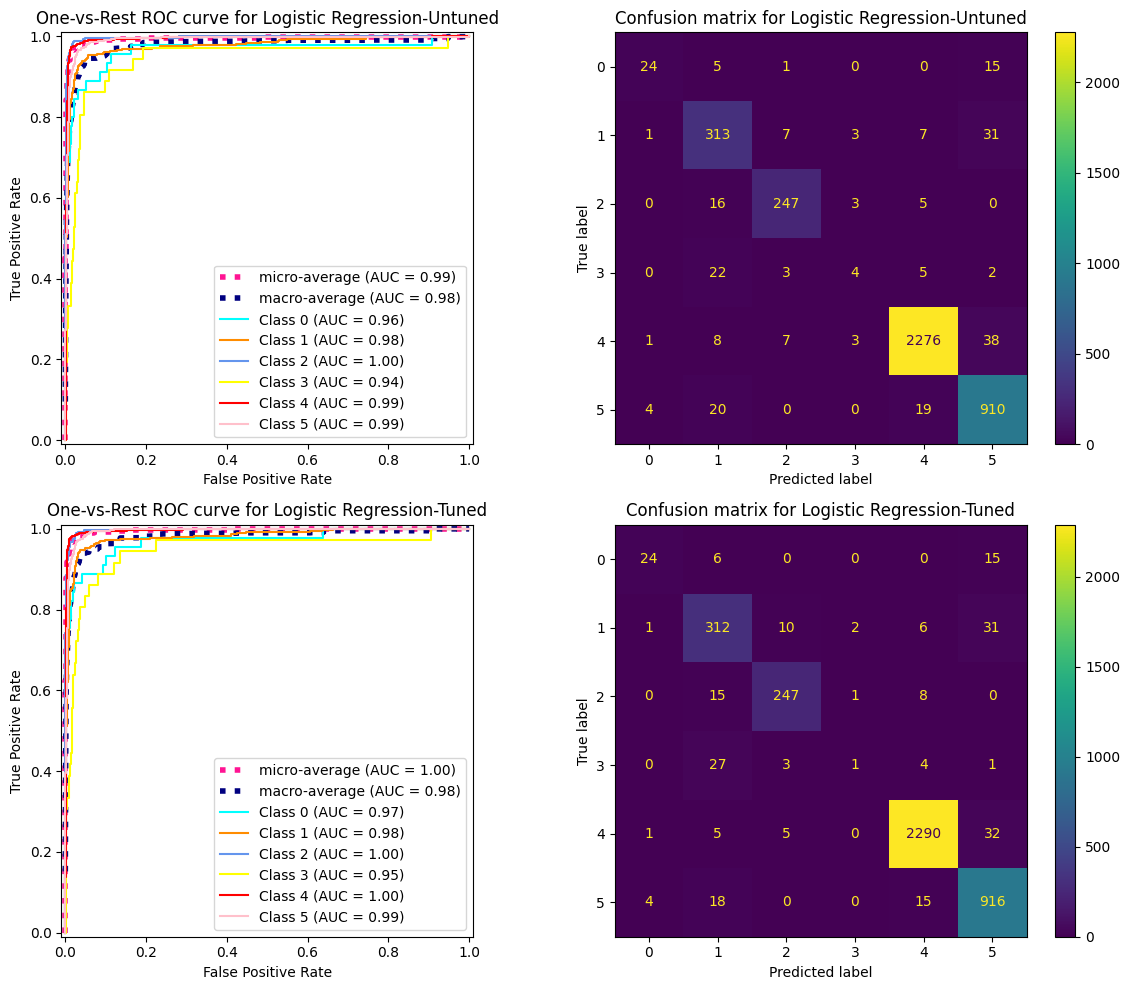

In [45]:
# Evaluation of Logistic Regression
model_evaluation(logistic,logistic_tuned,"Logistic Regression")

<a id='decisiontree_evaluation'></a>

Class 0 = Crimes against Persons
Class 1 = Crimes against Public Order
Class 2 = Fraud and White-Collar Crimes
Class 3 = Other Crimes
Class 4 = Property Crimes
Class 5 = Violent Crimes

Classification report for Decision Tree-Untuned

              precision    recall  f1-score   support

           0       0.55      0.60      0.57        45
           1       0.77      0.78      0.77       362
           2       0.87      0.88      0.87       271
           3       0.22      0.31      0.26        36
           4       0.98      0.98      0.98      2333
           5       0.93      0.92      0.92       953

    accuracy                           0.93      4000
   macro avg       0.72      0.74      0.73      4000
weighted avg       0.93      0.93      0.93      4000


Classification report for Decision Tree-Tuned

              precision    recall  f1-score   support

           0       0.61      0.42      0.50        45
           1       0.77      0.80      0.78       362
           

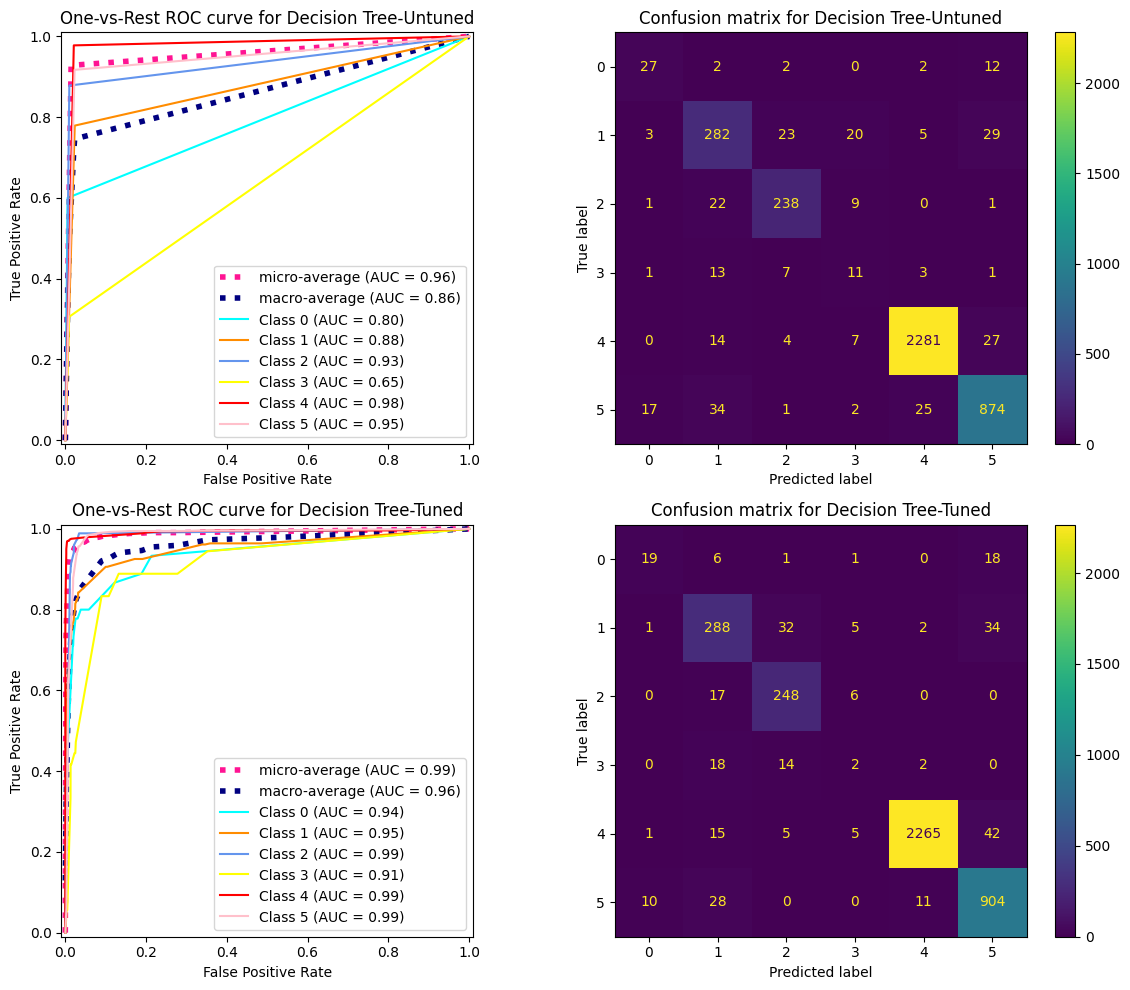

In [46]:
# Evaluation of Decision Tree
model_evaluation(decisiontree,decisiontree_tuned,"Decision Tree")

<a id='knn_evaluation'></a>

Class 0 = Crimes against Persons
Class 1 = Crimes against Public Order
Class 2 = Fraud and White-Collar Crimes
Class 3 = Other Crimes
Class 4 = Property Crimes
Class 5 = Violent Crimes

Classification report for K-Nearest Neighbor-Untuned

              precision    recall  f1-score   support

           0       0.65      0.49      0.56        45
           1       0.69      0.68      0.68       362
           2       0.86      0.79      0.82       271
           3       0.11      0.03      0.04        36
           4       0.90      0.94      0.92      2333
           5       0.86      0.81      0.83       953

    accuracy                           0.86      4000
   macro avg       0.68      0.62      0.64      4000
weighted avg       0.86      0.86      0.86      4000


Classification report for K-Nearest Neighbor-Tuned

              precision    recall  f1-score   support

           0       0.94      0.38      0.54        45
           1       0.81      0.71      0.76       362
 

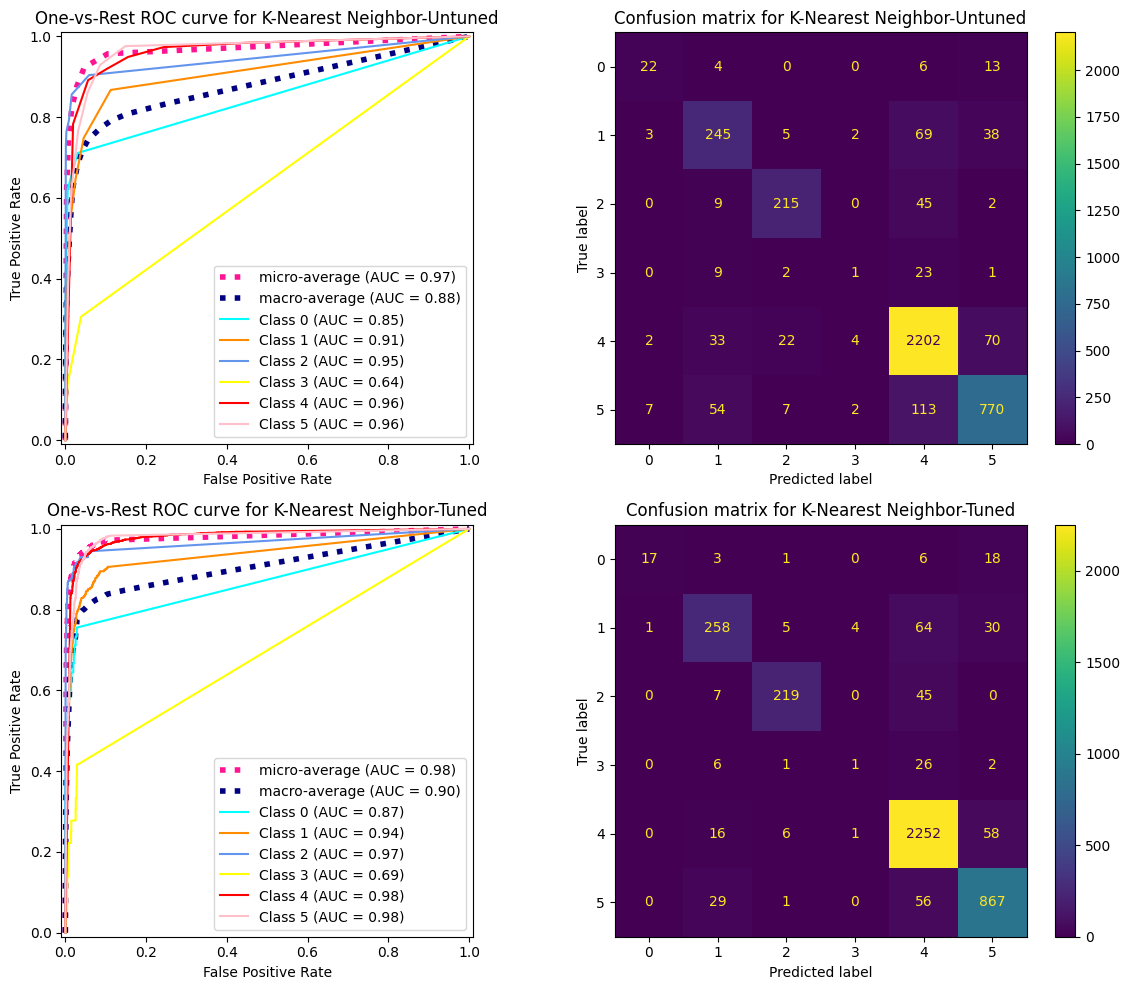

In [47]:
# Evaluation of knn
model_evaluation(knn,knn_tuned,"K-Nearest Neighbor")

<a id='mlp_evaluation'></a>

Class 0 = Crimes against Persons
Class 1 = Crimes against Public Order
Class 2 = Fraud and White-Collar Crimes
Class 3 = Other Crimes
Class 4 = Property Crimes
Class 5 = Violent Crimes

Classification report for Multi-layer perceptron-Untuned

              precision    recall  f1-score   support

           0       0.65      0.44      0.53        45
           1       0.81      0.83      0.82       362
           2       0.94      0.92      0.93       271
           3       0.26      0.25      0.26        36
           4       0.98      0.97      0.98      2333
           5       0.91      0.93      0.92       953

    accuracy                           0.93      4000
   macro avg       0.76      0.72      0.74      4000
weighted avg       0.93      0.93      0.93      4000


Classification report for Multi-layer perceptron-Tuned

              precision    recall  f1-score   support

           0       0.78      0.40      0.53        45
           1       0.81      0.86      0.84    

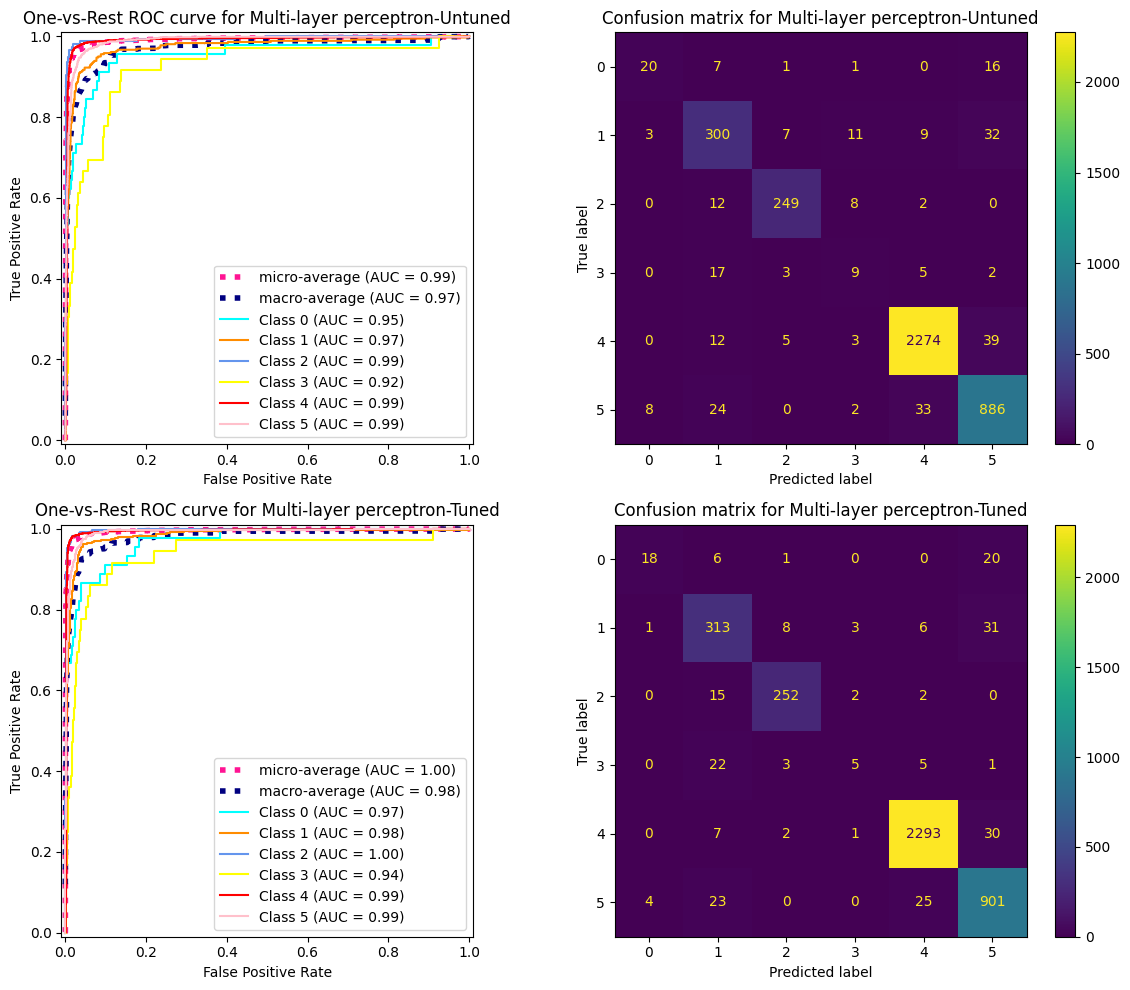

In [48]:
# Evaluation of mlp
model_evaluation(mlp,mlp_tuned,"Multi-layer perceptron")

<a id='bagging_evaluation'></a>

Class 0 = Crimes against Persons
Class 1 = Crimes against Public Order
Class 2 = Fraud and White-Collar Crimes
Class 3 = Other Crimes
Class 4 = Property Crimes
Class 5 = Violent Crimes

Classification report for Bagging-Untuned

              precision    recall  f1-score   support

           0       0.66      0.56      0.60        45
           1       0.79      0.84      0.82       362
           2       0.89      0.93      0.91       271
           3       0.37      0.28      0.32        36
           4       1.00      0.98      0.99      2333
           5       0.93      0.95      0.94       953

    accuracy                           0.95      4000
   macro avg       0.77      0.76      0.76      4000
weighted avg       0.95      0.95      0.94      4000


Classification report for Bagging-Tuned

              precision    recall  f1-score   support

           0       0.86      0.53      0.66        45
           1       0.84      0.84      0.84       362
           2       0.93

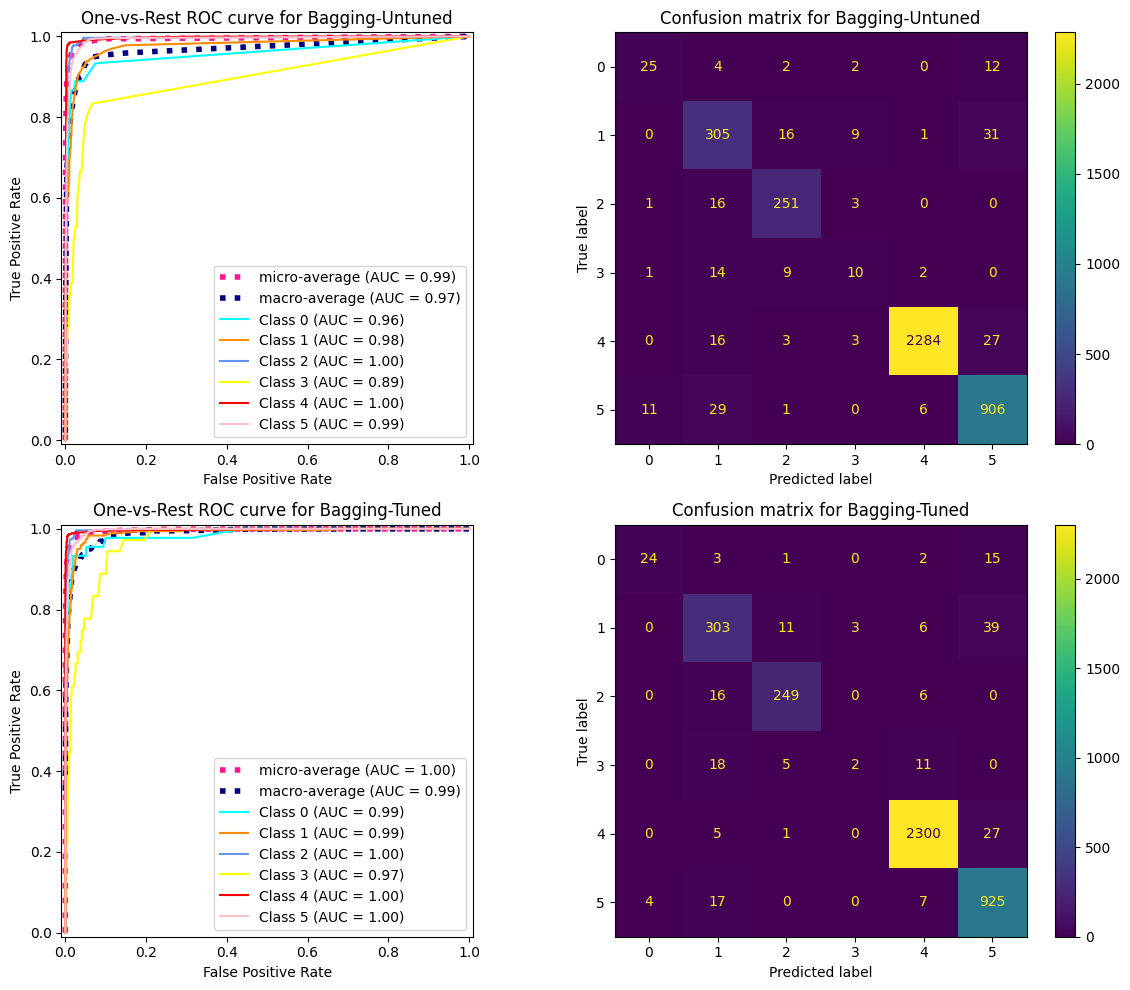

In [49]:
# Evaluation of Bagging
model_evaluation(bagging,bagging_tuned,"Bagging")

<a id='extra_tree_evaluation'></a>

Class 0 = Crimes against Persons
Class 1 = Crimes against Public Order
Class 2 = Fraud and White-Collar Crimes
Class 3 = Other Crimes
Class 4 = Property Crimes
Class 5 = Violent Crimes

Classification report for Extra Tree-Untuned

              precision    recall  f1-score   support

           0       0.93      0.29      0.44        45
           1       0.83      0.84      0.84       362
           2       0.92      0.94      0.93       271
           3       0.40      0.06      0.10        36
           4       0.99      0.98      0.99      2333
           5       0.91      0.97      0.94       953

    accuracy                           0.95      4000
   macro avg       0.83      0.68      0.70      4000
weighted avg       0.95      0.95      0.94      4000


Classification report for Extra Tree-Tuned

              precision    recall  f1-score   support

           0       0.92      0.27      0.41        45
           1       0.83      0.83      0.83       362
           2     

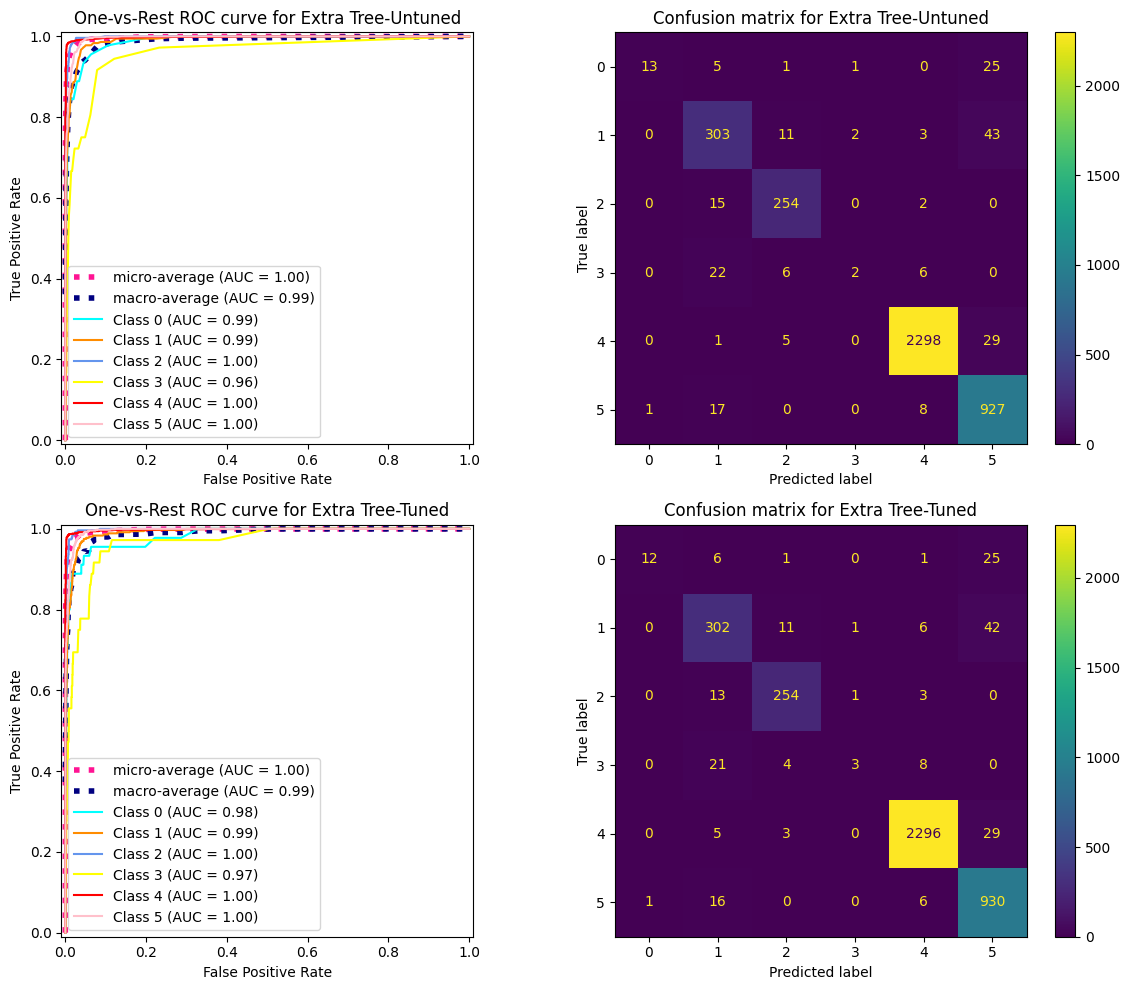

In [50]:
# Evaluation of Extra tree
model_evaluation(extratree,extratree_tuned,"Extra Tree")

<a id='stacking_evaluation'></a>

Class 0 = Crimes against Persons
Class 1 = Crimes against Public Order
Class 2 = Fraud and White-Collar Crimes
Class 3 = Other Crimes
Class 4 = Property Crimes
Class 5 = Violent Crimes

Classification report for Stacking-Untuned

              precision    recall  f1-score   support

           0       0.86      0.71      0.78        45
           1       0.81      0.91      0.86       362
           2       0.96      0.94      0.95       271
           3       0.46      0.17      0.24        36
           4       0.99      0.99      0.99      2333
           5       0.95      0.95      0.95       953

    accuracy                           0.96      4000
   macro avg       0.84      0.78      0.80      4000
weighted avg       0.96      0.96      0.96      4000


Classification report for Stacking-Tuned

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        45
           1       0.82      0.91      0.86       362
           2       0.

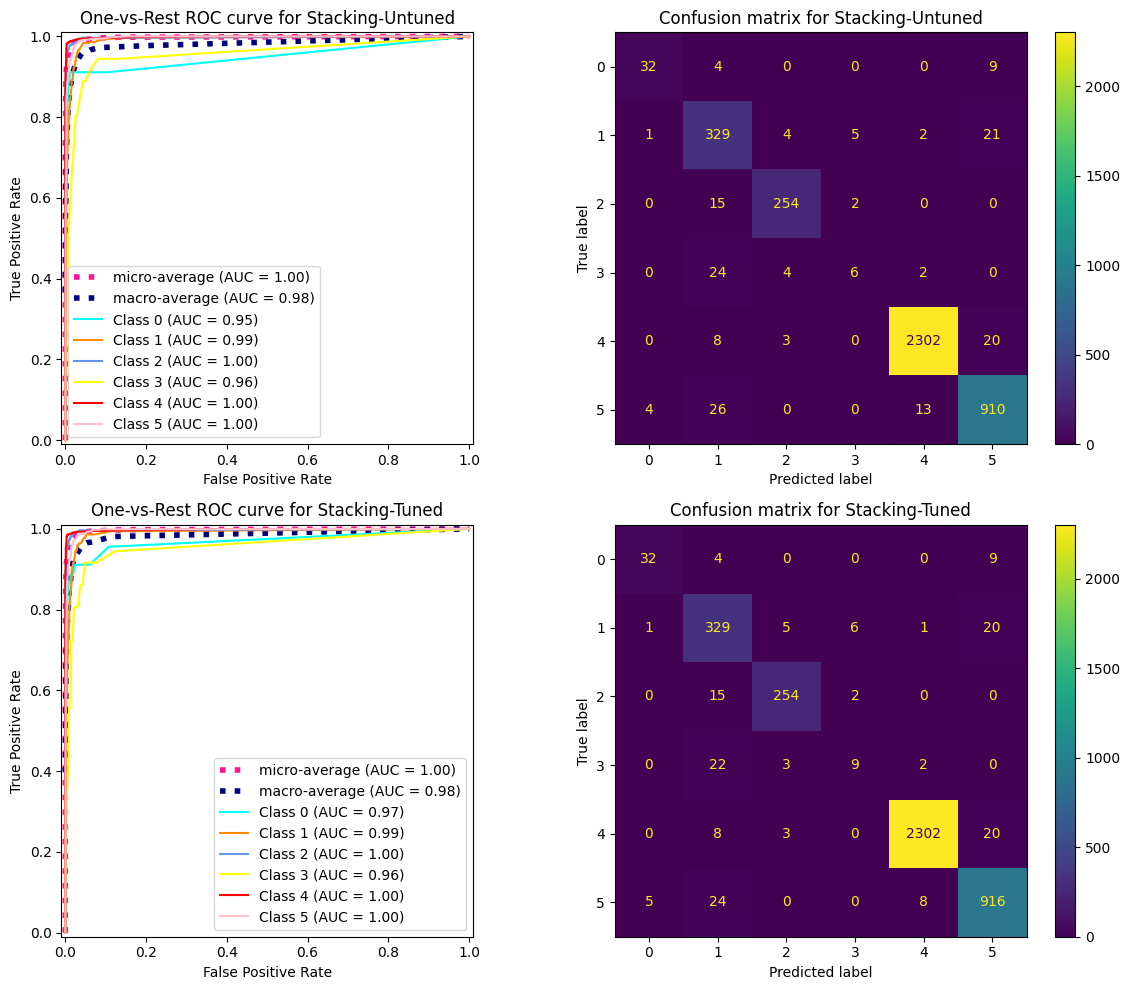

In [12]:
# Evaluation of Stacking
model_evaluation(stacking,stacking_tuned,"Stacking")

The following metrics are used to compare the models (all the scores are rounded off upto 2 decimal places):

1. **Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positives.

2. **Recall**: Recall is the ratio of correctly predicted positive observations to all observations in the actual class. 

3. **F1-Score**: The F1-Score is the weighted average of precision and recall, providing a balance between the two. 

4. **Accuracy**: Accuracy is the ratio of correctly predicted observations to the total observations. 

5. **ROC AUC**: The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score shows the relationship between true positive rate and false positive rate(1- true negative rate) at various thresholds.

### Model Comparison

1. **Logistic Regression**
    - **Untuned**: Shows high accuracy (0.94), but precision and recall for less frequent classes like Class 0 and Class 3 are lower, indicating that the model struggles with those.
    - **Tuned**: Overall performance remains similar, with a decrease in recall and precision scores for Class 3.


2. **Decision Tree**
    - **Untuned**: High accuracy (0.93) but struggles with less frequent classes, showing lower precision and recall.
    - **Tuned**: The ROC score for all classes increased quite significantly.


3. **K-Nearest Neighbor (KNN)**
    - **Untuned**: Lower accuracy (0.86) compared to other models. Precision and recall are weaker.
    - **Tuned**: Increase in accuracy score (0.90). Precision improved for all classes, and recall increased for Classes 1, 2, 4, and 5. Slight improvement in ROC scores for all the classes.


4. **Multi-layer Perceptron (MLP)**
    - **Untuned**: Good overall accuracy (0.93) and ROC score. Precision and recall are solid across most classes but weaker in smaller classes.
    - **Tuned**: Increase in accuracy score (0.95). Precision increased for class 0 and 3, whereas the recall decreased.


5. **Bagging**
    - **Untuned**: High accuracy (0.95) with decent precision and recall across all classes compared to the previous models. It’s one of the more balanced models.
    - **Tuned**: Precision improved for most of the classes, with the overall macro-average ROC score reaching 0.99, indicating excellent performance.


6. **Extra Tree**
    - **Untuned**: Lower F1-Scores for Classes 0 and 3 despite high overall accuracy.
    - **Tuned**: No significant improvement in performance.


7. **Stacking Classifier**
    - **Untuned**: Shows high overall accuracy (0.96), with well-balanced precision and recall across all classes. The model particularly improves precision and recall for Class 0, where other models struggled.
    - **Tuned**: Further enhancements are seen in the F1-Score for Classe 3.

### Summary

- **Stacking Classifier** stands out as one of the most effective models after tuning, offering a higher degree of accuracy, precision, recall, and ROC AUC across all classes compared to other models.
- **Bagging** and **Extra Trees** are strong contenders, with their ability to handle complex patterns.
- **Logistic Regression** and **MLP** are also solid choices, especially after tuning, while **KNN** and **Decision Tree** lag behind in performance.
- **Class 3** (Other Crimes) remains a challenge, but the Stacking Classifier shows significant improvement in this area, making it the most reliable choice for this specific task.

# Selection of the best model and saving the output

In [13]:
model = stacking_tuned
res=pd.DataFrame(transformerY.inverse_transform(model.predict(X_test_transformed)))
res.index+=1
res=res.reset_index()
res.columns=['ID','Crime_Category']
res.to_csv(r'/kaggle/working/submission.csv',index=False)